<a href="https://colab.research.google.com/github/calibretaliation/DeepLearning20211/blob/main/siamese_net_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/calibretaliation/DeepLearning20211.git

Cloning into 'DeepLearning20211'...
remote: Enumerating objects: 32505, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 32505 (delta 22), reused 0 (delta 0), pack-reused 32466
Receiving objects: 100% (32505/32505), 1.68 GiB | 28.03 MiB/s, done.
Resolving deltas: 100% (80/80), done.
Checking out files: 100% (32428/32428), done.


## Import

In [1]:
#@title Import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import math
import random

import os

import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications, layers, losses, optimizers, metrics, Model
from tensorflow.keras.applications import resnet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD


from pathlib import Path


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [2]:
#@title Load CSV

train_df = pd.read_csv('DeepLearning20211/data/train.csv')
test_df = pd.read_csv('DeepLearning20211/data/test.csv')

train_img_dir = Path('DeepLearning20211/data/train_images')
test_img_dir = Path('DeepLearning20211/data/test_images/')

In [3]:
#@title Drop images with duplicated p-hash value

train_df = train_df.drop_duplicates(subset=['image_phash']).reset_index(drop=True)

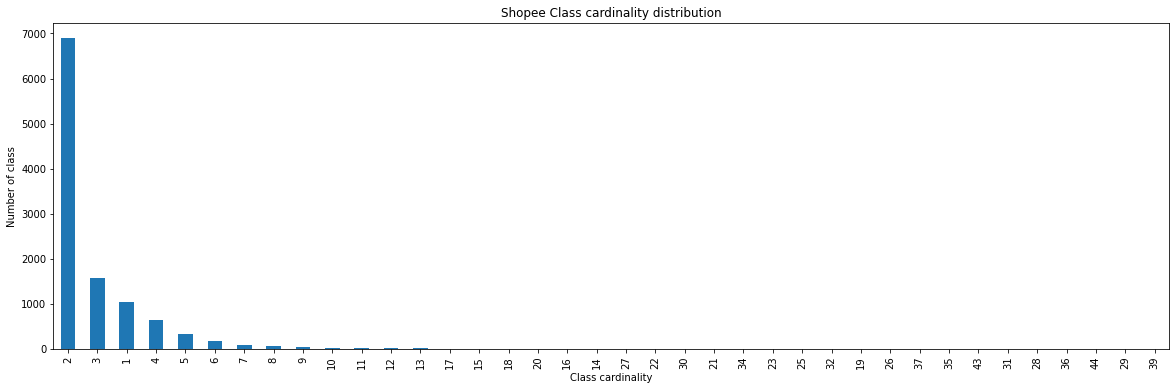

In [4]:
#@title Plot class cardinality distribution

# calculate number of images in each class
label_count = train_df['label_group'].value_counts()

plt.figure(figsize=(20, 6))
label_count.value_counts().plot.bar()
plt.xlabel('Class cardinality')
plt.ylabel('Number of class')
plt.title('Shopee Class cardinality distribution')
plt.show()

In [5]:
#@title Create validation set
val_df = train_df.sample(frac=1, random_state=14).groupby('label_group').nth(0)
val_df['label_group'] = val_df.index
val_df = val_df.reset_index(drop=True)

## Prepare dataset

In [6]:
#@title Take one instance in each class as anchor

set_seed(42)
anchor_df = train_df.groupby('label_group').nth(0)

In [7]:
num_triplets = 3

In [8]:
def create_dataset(mode):
    assert mode == 'training' or mode == 'validation', "argument mode should be 'training' or 'validation'" 
    df = train_df if mode == 'training' else val_df

    # container to store image path
    anchor_container = []
    positive_container = []
    negative_container = []

    # for each anchor image, create num_triplets triplets
    for anchor_label in anchor_df.index:
        anchor = anchor_df['image'][anchor_label]

        positive_df = df[df['label_group'] == anchor_label]
        if len(positive_df) > 1:
            positive_df = positive_df[positive_df['image'] != anchor]
        negative_df = df[df['label_group'] != anchor_label]
        for _ in range(num_triplets):
            anchor_container.append(str(train_img_dir) + os.sep + anchor)
            positive_container.append(str(train_img_dir) + os.sep + np.squeeze(positive_df.sample(1)['image']))
            negative_container.append(str(train_img_dir) + os.sep + np.squeeze(negative_df.sample(1)['image']))

    return anchor_container, positive_container, negative_container

In [9]:
train_ds_raw = create_dataset(mode='training')
val_ds_raw = create_dataset(mode='validation')

In [10]:
train_ds = tf.data.Dataset.from_tensor_slices(train_ds_raw)
val_ds = tf.data.Dataset.from_tensor_slices(val_ds_raw)

In [25]:
resize_and_scale = tf.keras.Sequential(
    [
     tf.keras.layers.Resizing(224, 224, crop_to_aspect_ratio=True),
     tf.keras.layers.Rescaling(1./255)
     ]
)

data_augmentation = tf.keras.Sequential(
    [
     tf.keras.layers.RandomFlip("vertical"),
     tf.keras.layers.RandomRotation(0.2),
     tf.keras.layers.RandomContrast(0.5),
     tf.keras.layers.RandomZoom((-0.2, 0.2)),
     tf.keras.layers.RandomTranslation(0.14, 0.14),
     ]
)

def filepath_to_img(filepath, augment=False):
    
    img_string = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img_string)

    if augment:
        img = data_augmentation(img)

    img = resize_and_scale(img)

    # img = resnet.preprocess_input(img)        ########################

    return img

def preprocess_input(anchor_path, positive_path, negative_path):
    return (
        filepath_to_img(anchor_path, augment=False),
        filepath_to_img(positive_path, augment=True),
        filepath_to_img(negative_path, augment=True)
    )

def configure_dataset(ds, mode):
    assert mode == 'training' or mode == 'validation', "mode should be 'training' or 'validation'" 
    
    if mode == 'training':
        ds = ds.shuffle(buffer_size=20000)
    
    ds = ds.map(preprocess_input, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.prefetch(buffer_size=256)

    if mode == 'validation':        ###############################
        ds = ds.cache()
    
    ds = ds.batch(32)
    
    return ds

train_ds = configure_dataset(train_ds, mode='training')
val_ds = configure_dataset(val_ds, mode='validation')


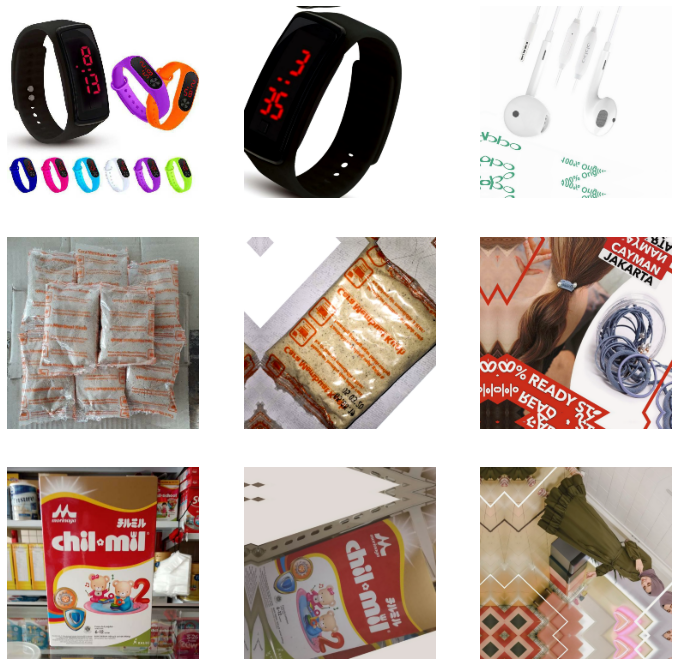

In [30]:
#@title Visualize some triplets

ncols = 3
nrows = 3
plt.figure(figsize=(4*ncols, 4*nrows))
spec = gridspec.GridSpec(ncols=ncols, nrows=nrows)
for anchor_batch, positive_batch, negative_batch in train_ds.take(1):
    i = 0
    for anchor, positive, negative in zip(anchor_batch, positive_batch, negative_batch):
        plt.subplot(spec[ncols*i])
        plt.imshow(anchor)
        plt.axis('off')
        plt.subplot(spec[ncols*i + 1])
        plt.imshow(positive)
        plt.axis('off')
        plt.subplot(spec[ncols*i + 2])
        plt.imshow(negative)
        plt.axis('off')
        
        i += 1
        if i == nrows:
            break
plt.show()

In [102]:
import shutil
shutil.rmtree(str(temp_dir), ignore_errors=True)

## Setup model

## Depricated

In [ ]:
#@title Depricated

min_cardinality = 4
max_cardinality = label_count.max()         # 39 in this dataset
augmented_list = []

progress = 0
for i in range(len(train_df)):
    # ten file: train_df.iloc[i]['image']
    # label_count[train_df.iloc[i]['label_group']]
    label_group = train_df.iloc[i]['label_group']
    class_cardinality = label_count[label_group]
    if class_cardinality < min_cardinality:
        progress += 1
        print(progress)
        img = image.load_img(train_img_dir/train_df.iloc[i]['image'])
        img = image.img_to_array(img)
        num_augmentation = math.ceil((min_cardinality - class_cardinality) / class_cardinality)
        for _ in range(num_augmentation):
            name = train_df.iloc[i]['image'][:-4] + '_AUGMENTED_' + str(_) + '.jpg'
            augmented_img = data_augmentation(img)
            image.save_img(train_img_dir/name, augmented_img)
            augmented_list.append({'image': name, 'label_group': label_group})


In [37]:
augmented_train_df = train_df.append(augmented_list, ignore_index=True)

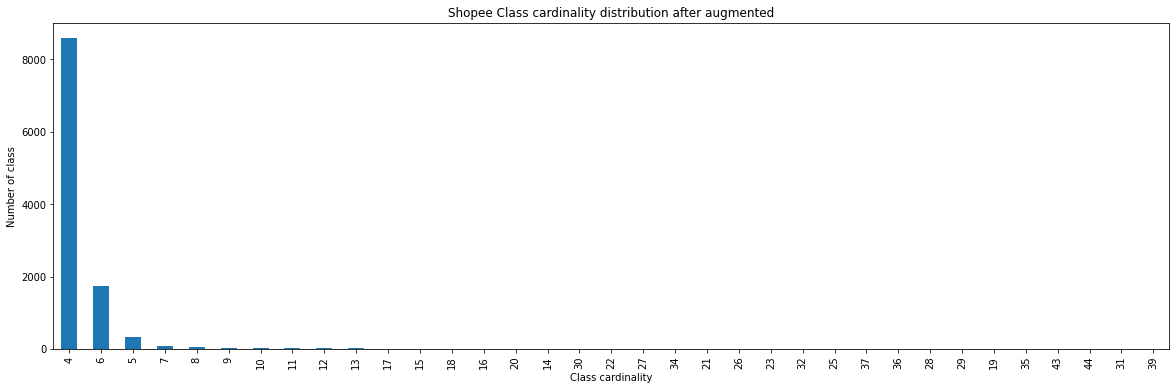

In [39]:
#@title Plot class cardinality distribution after augmentation

# calculate number of images in each class
augmented_label_count = augmented_train_df['label_group'].value_counts()

plt.figure(figsize=(20, 6))
augmented_label_count.value_counts().plot.bar()
plt.xlabel('Class cardinality')
plt.ylabel('Number of class')
plt.title('Shopee Class cardinality distribution after augmented')
plt.show()